In [1]:
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
from pathlib import Path

import tensorflow as tf
import tflib as lib
import tflib.ops.linear

from differential_privacy.dp_sgd.dp_optimizer import dp_optimizer
from differential_privacy.dp_sgd.dp_optimizer import sanitizer
from differential_privacy.privacy_accountant.tf import accountant

from scipy.stats import wasserstein_distance

from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras import optimizers
from keras.utils import multi_gpu_model

Using TensorFlow backend.


In [2]:
def loadfile(filename):
    pickle_in = open("C:/Users/Akarsh/Downloads/DP_scripts/store_emb/" + filename + ".pickle","rb")
    return pickle.load(pickle_in)

def save2file(filename, data):
    pickle_out = open("C:/Users/Akarsh/Downloads/DP_scripts/store_emb/" + filename + ".pickle", "wb")
    pickle.dump(data, pickle_out, protocol=pickle.HIGHEST_PROTOCOL)
    pickle_out.close()

main_str = str(437)

filename = "gan_train_" + main_str
gan_data = loadfile(filename)
display(gan_data.head())
print(gan_data.shape)

,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
0,1,0,0,0,0,0,0,0.460752,0.690727,0.289209,...,0.459836,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0.704294,0.457027,0.217206,...,0.565490,0,1,0,0,1,0,1,0,0
2,0,0,0,0,1,0,0,0.763681,0.690727,0.289209,...,0.314966,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0,0.463889,0.690727,0.289209,...,0.681866,0,1,0,0,1,0,1,0,0
4,0,0,0,0,0,1,0,0.743854,0.690727,0.289209,...,0.314966,0,1,0,0,0,0,1,0,0


(260391, 160)


In [3]:
# Configuration Parameter
DEVICES = ['/cpu:0']
MODE = "dp_wgan_gp" #wgan #wgan_gp
num_epochs = int(10);             BATCH_SIZE = int(2048);   input_length_noise = int(100)
fully_connected_dim = int(2048);    LAMBDA = 10 # Gradient penalty lambda hyperparameter
TTUR = False;      gen_examples = len(gan_data);     add_noise_to_real_data = False;

if TTUR:
    CRITIC_ITERS = 1 # disc train iterations
    D_LR = 0.0003
    G_LR = 0.0001
    BETA1_D = 0.0
    BETA1_G = 0.0
else:
    CRITIC_ITERS = 5 # disc train iterations
    D_LR = 0.0005
    G_LR = 0.0005
    BETA1_D = 0.0
    BETA1_G = 0.0

# privacy settings
decay_l2norm = True
l2norm_bound = 0.03
decay_value = 1
classify = False
moment_orders = 18
target_delta = 1/gan_data.shape[0]
lot_size = 1 #int(np.floor(np.sqrt(gen_examples)))
noise_ = 0.5

df = pd.DataFrame.from_records([{'operation': 'dp_wgan_train', 'main_str': main_str, 'fully_connected_dim': fully_connected_dim,
                                 'batch_size': BATCH_SIZE, 'l2norm_bound': l2norm_bound,
                                     'noise': noise_, 'target_delta': target_delta, 'disc_iters': CRITIC_ITERS, 'disc_lr': D_LR,
                                     'gen_lr': G_LR, 'TTUR': TTUR, 'gen_examples_len': gen_examples, "moment_orders": moment_orders,
                                     'add_noise_to_real_data': add_noise_to_real_data, 
                                 'decay_l2norm': decay_l2norm, 'classify': classify, 'lot_size':lot_size}])
display(df)

for i in range(num_epochs):
    print(round(l2norm_bound * (1 - (i / 10)*decay_value), 4))

,operation,main_str,fully_connected_dim,batch_size,l2norm_bound,noise,target_delta,disc_iters,disc_lr,gen_lr,TTUR,gen_examples_len,moment_orders,add_noise_to_real_data,decay_l2norm,classify,lot_size
0,dp_wgan_train,437,1024,2048,0.03,0.5,0.000004,5,0.0005,0.0005,False,260391,18,False,True,False,1


0.03
0.027
0.024
0.021
0.018
0.015
0.012
0.009
0.006
0.003


In [4]:
counter_read = 0;      input_length_data = -1;
class NetflowDataFlow():
    def __init__(self, data_file):
        def prepare_data(dp):
            global input_length_data
            global counter_read
            if input_length_data == -1: 
                input_length_data = dp.shape[1]
            lst = []
            for val in list(dp.values):
                counter_read += 1
                if counter_read % 50000 == 0:
                    print("Read lines: ", str(counter_read))
                lst.append(val)
            return lst
        print("Converting data...")
        self.data = prepare_data(gan_data)
        print("Data converted")
        random.shuffle(self.data)
        
        self.size = len(self.data)
        print(self.size)
        self.pointer = 0
    
    def sample(self, N):
        if self.pointer + N > self.size -1: 
            self.pointer = 0 
            random.shuffle(self.data)
        samples = self.data[self.pointer:self.pointer+N]
        if add_noise_to_real_data: 
            for q in range(0,N):
                noise = np.random.uniform(-0.05,0.05, input_length_data)
                samples[q] = samples[q] + noise
        self.pointer = self.pointer + N
        return samples

    def __len__(self):
        return self.size

ndf = NetflowDataFlow(gan_data)
DIM = input_length_data
print("Data_DIM, Training_rows: ", DIM, ',', counter_read)

Converting data...
Read lines:  50000
Read lines:  100000
Read lines:  150000
Read lines:  200000
Read lines:  250000
Data converted
260391
Data_DIM, Training_rows:  160 , 260391


In [5]:
# classification part
def real_label_encoded(fake_data):
    rl = []
    for row in fake_data[:, 157:]:
        normal = 0.0; attacker = 0.0; victim = 0.0
        c_id = np.array(row, dtype=np.float32).argmax()
        if c_id == 0:
            rl.append([1, 0, 0]) #normal
        if c_id == 1:
            rl.append([0, 1, 0]) #attacker
        if c_id == 2:
            rl.append([0, 0, 1]) #victim
    fake_with_real_labels = np.concatenate((fake_data[:, :157], np.array(rl).astype(int)), axis=1)
    return fake_with_real_labels

def split_stratify(data):
    # pass numpy array
    train_data, test_data = train_test_split(data, test_size = 0.33, random_state = 1, shuffle = True, stratify = data[:, 157:])
    x_train = train_data[:, :157]; y_train = train_data[:, 157:]
    x_test = test_data[:, :157]; y_test = test_data[:, 157:]
    return x_train, y_train, x_test, y_test

def classification_model(mode, classify_model, eps, lr, units, dropout, bs, x_train, y_train, x_test, y_test, plot_title):
    if classify_model == "autoencoder":
        input_img = Input(shape=(157,))
        encoded = Dense(units, kernel_initializer ='he_normal', activation='relu')(input_img)
        encoded = Dropout(dropout)(encoded)
        encoded = Dense(int(units/2), kernel_initializer ='he_normal', activation='relu')(encoded)
        encoded = Dropout(dropout)(encoded)
        encoded = Dense(int(units/4), kernel_initializer ='he_normal', activation='relu')(encoded)
        
        decoded = Dense(int(units/2), kernel_initializer ='he_normal', activation='relu')(encoded)
        encoded = Dropout(dropout)(encoded)
        decoded = Dense(units, kernel_initializer ='he_normal', activation='relu')(decoded)
        encoded = Dropout(dropout)(encoded)
        decoded = Dense(3, kernel_initializer ='he_normal', activation='softmax')(decoded)
        
        mdl = Model(input_img, decoded)
        
    elif classify_model == "mlp":
        input_img = Input(shape=(157,))
        x = Dense(units, kernel_initializer ='he_normal', activation='relu')(input_img)
        x = Dropout(dropout)(x)
        
        x = Dense(units, kernel_initializer ='he_normal', activation='relu')(x)
        x = Dropout(dropout)(x)
                
        x = Dense(units, kernel_initializer ='he_normal', activation='relu')(x)
        x = Dropout(dropout)(x)
        
        x = Dense(units, kernel_initializer ='he_normal', activation='relu')(x)
        x = Dropout(dropout)(x)
        
        x = Dense(3, kernel_initializer ='he_normal', activation='softmax')(x)
        mdl = Model(input_img, x)

    if mode == "multi":
        num_gpu = 0
        parallel_model = multi_gpu_model(mdl, gpus=num_gpu)
        opt = optimizers.Adam(learning_rate=lr, beta_1=0.0, beta_2=0.9)
        parallel_model.compile(loss ='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
        history = parallel_model.fit(x_train, y_train, 
                                   epochs=eps,
                                   batch_size= bs,
                                   shuffle=True,
                                   validation_data=(x_test, y_test))
    else:
        opt = optimizers.Adam(learning_rate=lr, beta_1=0.0, beta_2=0.9)
        mdl.compile(loss ='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
        history = mdl.fit(x_train, y_train, 
                                   epochs=eps,
                                   batch_size= bs,
                                   shuffle=True,
                                   validation_data=(x_test, y_test))
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy of ' + plot_title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss of ' + plot_title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [6]:
def GeneratorAndDiscriminator():
    return FCGenerator, FCDiscriminator

def LeakyReLU(x, alpha=0.2):
    return tf.maximum(alpha*x, x)

def ReLULayer(name, n_in, n_out, inputs):
    output = lib.ops.linear.Linear(name+'.Linear', n_in, n_out, inputs, initialization='he')
    return tf.nn.relu(output)

def LeakyReLULayer(name, n_in, n_out, inputs):
    output = lib.ops.linear.Linear(name+'.Linear', n_in, n_out, inputs, initialization='he')
    return LeakyReLU(output)

def FCGenerator(n_samples, noise=None, FC_DIM=fully_connected_dim):
    if noise is None:
        noise = tf.random_normal([n_samples, input_length_noise])

    output = ReLULayer('Generator.1', input_length_noise, FC_DIM, noise)
    output = ReLULayer('Generator.2', FC_DIM, FC_DIM, output)
    output = ReLULayer('Generator.3', FC_DIM, FC_DIM, output)
    output = ReLULayer('Generator.4', FC_DIM, FC_DIM, output)
    output = ReLULayer('Generator.Out', FC_DIM, input_length_data, output)
    return output

def FCDiscriminator(inputs, FC_DIM=fully_connected_dim, n_layers=3):
    output = LeakyReLULayer('Discriminator.Input', input_length_data, FC_DIM, inputs)
    for i in range(n_layers):
        output = LeakyReLULayer('Discriminator.{}'.format(i), FC_DIM, FC_DIM, output)
    output = lib.ops.linear.Linear('Discriminator.Out', FC_DIM, 1, output)
    return tf.reshape(output, [-1])

Generator, Discriminator = GeneratorAndDiscriminator()

In [7]:
all_real_data_conv = tf.placeholder(tf.float32, shape=[BATCH_SIZE, input_length_data])

if tf.__version__.startswith('1.'):
    split_real_data_conv = tf.split(all_real_data_conv, len(DEVICES))
else:
    split_real_data_conv = tf.split(0, len(DEVICES), all_real_data_conv)
gen_costs, disc_costs = [],[]

for device_index, (device, real_data_conv) in enumerate(zip(DEVICES, split_real_data_conv)):
    with tf.device(device):

        real_data = real_data_conv
        fake_data = Generator(BATCH_SIZE//len(DEVICES))
        
        disc_fake = Discriminator(fake_data)
        disc_real = Discriminator(real_data)
        
        if MODE == 'wgan':
            gen_cost = -tf.reduce_mean(disc_fake)
            disc_cost = tf.reduce_mean(disc_fake) - tf.reduce_mean(disc_real)

        if MODE == 'wgan_gp':
            gen_cost = -tf.reduce_mean(disc_fake)
            disc_cost = tf.reduce_mean(disc_fake) - tf.reduce_mean(disc_real)

            alpha = tf.random_uniform(shape=[BATCH_SIZE//len(DEVICES),1], minval=0., maxval=1.)
            differences = fake_data - real_data
            interpolates = real_data + (alpha*differences)
            gradients = tf.gradients(Discriminator(interpolates), interpolates)[0]
            slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
            gradient_penalty = tf.reduce_mean((slopes-1.)**2)
            disc_cost += LAMBDA*gradient_penalty
            
        if MODE == 'dp_wgan_gp':
            gen_cost = -tf.reduce_mean(disc_fake)
            disc_cost = tf.reduce_mean(disc_fake) - tf.reduce_mean(disc_real)

            alpha = tf.random_uniform(shape=[BATCH_SIZE//len(DEVICES),1], minval=0., maxval=1.)
            differences = fake_data - real_data
            interpolates = real_data + (alpha*differences)
            gradients = tf.gradients(Discriminator(interpolates), interpolates)[0]
            slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
            gradient_penalty = tf.reduce_mean((slopes-1.)**2)
            disc_cost += LAMBDA*gradient_penalty
            
            # differential privacy
            eps = tf.placeholder(tf.float32)
            delta = tf.placeholder(tf.float32)
            priv_accountant = accountant.GaussianMomentsAccountant(len(gan_data), moment_orders)
            clip = True
            if decay_l2norm:
                iteration_decay = tf.placeholder(tf.float32)
                gaussian_sanitizer = sanitizer.AmortizedGaussianSanitizer(priv_accountant,
                                                                          [tf.multiply(l2norm_bound,iteration_decay), clip], 
                                                                          lib.params_with_name('Discriminator.'))
            else:
                gaussian_sanitizer = sanitizer.AmortizedGaussianSanitizer(priv_accountant, [l2norm_bound, clip], 
                                                                          lib.params_with_name('Discriminator.'))

            iterationW = tf.placeholder(tf.float32)
            disc_train_op, sanitized_grads, clipped_grads, not_sanitized_grads, bound, a  = dp_optimizer.DPGradientDescentOptimizer(
                D_LR, 
                [eps, delta], 
                sanitizer = gaussian_sanitizer, 
                sigma = noise_,
                batches_per_lot = lot_size).minimize(disc_cost, iteration = iterationW, var_list = lib.params_with_name('Discriminator.'))

            if len(lib.params_with_name('Generator')) > 0:
                gen_train_op = tf.train.AdamOptimizer(learning_rate=G_LR, beta1 = BETA1_G, beta2 = 0.9).minimize(gen_cost, var_list = lib.params_with_name('Generator'))
            else:
                gen_train_op = tf.no_op()
                
        gen_costs.append(gen_cost)
        disc_costs.append(disc_cost)

gen_cost = tf.add_n(gen_costs) / len(DEVICES)
disc_cost = tf.add_n(disc_costs) / len(DEVICES)

if MODE == 'wgan':
    gen_train_op = tf.train.RMSPropOptimizer(learning_rate=G_LR).minimize(gen_cost,
                                         var_list=lib.params_with_name('Generator'), colocate_gradients_with_ops=True)
    disc_train_op = tf.train.RMSPropOptimizer(learning_rate=D_LR).minimize(disc_cost,
                                         var_list=lib.params_with_name('Discriminator.'), colocate_gradients_with_ops=True)
    clip_ops = []
    for var in lib.params_with_name('Discriminator'):
        clip_bounds = [-.01, .01]
        clip_ops.append(tf.assign(var, tf.clip_by_value(var, clip_bounds[0], clip_bounds[1])))
    clip_disc_weights = tf.group(*clip_ops)

if MODE == 'wgan_gp':
    gen_train_op = tf.train.AdamOptimizer(learning_rate=G_LR, beta1=BETA1_G, beta2=0.9).minimize(gen_cost,
                                      var_list=lib.params_with_name('Generator'), colocate_gradients_with_ops=True)
    disc_train_op = tf.train.AdamOptimizer(learning_rate=D_LR, beta1=BETA1_D, beta2=0.9).minimize(disc_cost,
                                       var_list=lib.params_with_name('Discriminator.'), colocate_gradients_with_ops=True)

# generating samples
fixed_noise = tf.constant(np.random.normal(size=(BATCH_SIZE, input_length_noise)).astype('float32'))
all_fixed_noise_samples = []
for device_index, device in enumerate(DEVICES):
    n_samples = BATCH_SIZE // len(DEVICES)
    all_fixed_noise_samples.append(Generator(n_samples,
                                             noise=fixed_noise[device_index*n_samples:(device_index+1)*n_samples]))
if tf.__version__.startswith('1.'):
    all_fixed_noise_samples = tf.concat(all_fixed_noise_samples, axis=0)
else:
    all_fixed_noise_samples = tf.concat(0, all_fixed_noise_samples)

# generating samples
samples_examples = Generator(gen_examples)
def generate_final_flows():
    samples = session.run(samples_examples)
    was = 0
    for i in range(samples.shape[1]):
        was += wasserstein_distance(samples[:, i], gan_data.values[:, i])         
    was /= samples.shape[1]
    return was, samples

def plotPrivacyMeasures(session):
    spent_deltas_eps = priv_accountant.get_privacy_spent(session, target_deltas = [target_delta])
    for (spent_eps, spent_delta) in spent_deltas_eps:
        print("epsilon: " + str(spent_eps))
        return spent_eps

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:
    session.run(tf.global_variables_initializer())
    ITERS = int((num_epochs * counter_read) / BATCH_SIZE )
    train_loss = []; w_dis = []; dp_epsilon = [];
    epoch = 0; epoch_wdis = 0; _gen_cost = 0;
    
    for iteration in range(ITERS):
        epoch = int((iteration * BATCH_SIZE) / counter_read)
        if MODE == 'wgan_gp':
            # Train generator
            if iteration > 0:
                _gen_cost, _ = session.run([gen_cost, gen_train_op])

            # Train discriminator
            for i in range(CRITIC_ITERS):
                _data = ndf.sample(BATCH_SIZE)
                _disc_cost, _ = session.run([disc_cost, disc_train_op], feed_dict={all_real_data_conv: _data})

                if MODE == "wgan":
                    _ = session.run([clip_disc_weights])
        
        if MODE == 'dp_wgan_gp':
            # Train generator
            if iteration > 0:
                _gen_cost, _ = session.run([gen_cost, gen_train_op], feed_dict={iterationW: (float(iteration + 1))})
            
            # Train the Discriminator
            for i in range(CRITIC_ITERS):
                curr_iter = (epoch % CRITIC_ITERS)
                _data = ndf.sample(BATCH_SIZE)
                if decay_l2norm:
                    iter_decay = 1 - (epoch / 10)*decay_value
                    _disc_cost, _ = session.run([disc_cost, disc_train_op], feed_dict={all_real_data_conv: _data,
                                                                                   iterationW: (float(curr_iter)), 
                                                                                   iteration_decay: round(iter_decay,4)})
                else:
                    _disc_cost, _ = session.run([disc_cost, disc_train_op], feed_dict={all_real_data_conv: _data, 
                                                                                       iterationW: (float(curr_iter))})
        
        if iteration % int((counter_read) / BATCH_SIZE ) == 0:
            print("\nStep ", iteration, " From ", ITERS, "(","Epoch", epoch,"): Disc_cost:", _disc_cost, " Gen_cost:", _gen_cost)
            stop_criterion = plotPrivacyMeasures(session)
            dp_epsilon.append(stop_criterion)
            print('current l2norm decay:', round(iter_decay*l2norm_bound,4))
            
            epoch_wdis, samples = generate_final_flows()
            print("Wasserstein dist:", epoch_wdis)
            w_dis.append(epoch_wdis)
            if epoch_wdis <= np.min(w_dis) and epoch > 4:
                print('best wdis so far...')
                save2file(MODE + "_epoch_" + str(epoch), samples)
            
            if classify:
                fake_with_real_labels = real_label_encoded(samples)
                realx_train, realy_train, realx_test, realy_test = split_stratify(gan_data.values)
                print("real data", realx_train.shape, realy_train.shape, realx_test.shape, realy_test.shape)

                fakex_train, fakey_train, fakex_test, fakey_test = split_stratify(fake_with_real_labels)
                print("fake data", fakex_train.shape, fakey_train.shape, fakex_test.shape, fakey_test.shape, '\n')

                # train on fake and test on real
                classification_model(mode='single', classify_model='mlp', eps=10, lr=0.0001, units=128, dropout=0.2, bs=256, 
                                     x_train=fakex_train, y_train=fakey_train, x_test=realx_test, y_test=realy_test, plot_title='Synthetic Data Tested on Real Data')

                # train on fake and test on fake
                classification_model(mode='single', classify_model='mlp', eps=5, lr=0.0001, units=128, dropout=0.2, bs=128, 
                                     x_train=fakex_train, y_train=fakey_train, x_test=fakex_test, y_test=fakey_test, plot_title='Synthetic Data Tested on Fake Data')
        
        train_loss.append([_gen_cost, _disc_cost])
    
    # Store final outputs
    finalwdis, samples = generate_final_flows()
    print("\nFinal Wasserstein dist:", finalwdis)
    if finalwdis < epoch_wdis:
        w_dis.append(finalwdis)
        save2file(MODE + "_final", samples)
        print('final output saved')
    else:
        print('training finished...')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Step  0  From  1271 ( Epoch 0 ): Disc_cost: -2.415845  Gen_cost: 0
epsilon: 6.357258600571068
current l2norm decay: 0.03
Wasserstein dist: 0.5855383079173139

Step  127  From  1271 ( Epoch 0 ): Disc_cost: -1.0037241  Gen_cost: 2.8867328
epsilon: 14.985265128886645
current l2norm decay: 0.03
Wasserstein dist: 0.11404356697257516

Step  254  From  1271 ( Epoch 1 ): Disc_cost: -0.8207396  Gen_cost: -1.1889422
epsilon: 17.482206544573145
current l2norm decay: 0.027
Wasserstein dist: 0.09811180002611472

Step  381  From  1271 ( Epoch 2 ): Disc_cost: -0.7735358  Gen_cost: -0.17541039
epsilon: 19.979147960260317
current l2norm decay: 0.024
Wasserstein dist: 0.08677590234667795

Step  508  From  1271 ( Epoch 3 ): Disc_cost: -0.5699328  Gen_cost: -1.3465025
epsilon: 22.47608937594522
current l2norm decay: 0.021
Wasserstein dist: 0.08333093879019943

Step  635  From  1271 ( Epoch 4 ): Disc_cost: -0.181

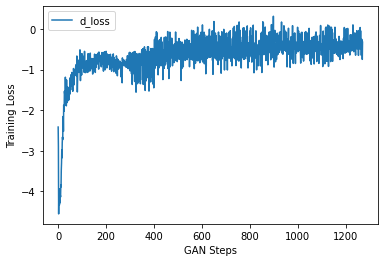

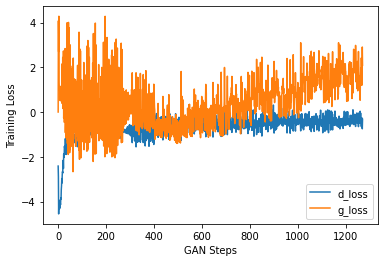

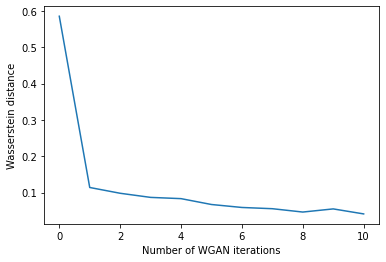

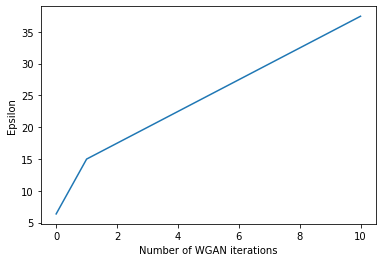

,operation,main_str,fully_connected_dim,batch_size,l2norm_bound,noise,target_delta,disc_iters,disc_lr,gen_lr,TTUR,gen_examples_len,moment_orders,add_noise_to_real_data,decay_l2norm,decay_rate,classify,privacy budget,final_wdis
0,dp_wgan_train,437,1024,2048,0.03,0.5,0.000004,5,0.0005,0.0005,False,260391,18,False,True,1,False,37.457738,0.041291


data and hyperparams saved...


In [8]:
save = True
if save:
    if MODE == 'wgan_gp':
        filename = MODE + '_train_loss_' + main_str
        save2file(filename, train_loss)
        
        filename = MODE + '_wass_dis'
        save2file(filename, w_dis)
        
        tt = np.arange(ITERS)
        plt.plot(tt, np.array(train_loss)[:, 1], label='d_loss')
        plt.plot(tt, np.array(train_loss)[:, 0], label='g_loss')
        plt.legend()
        plt.xlabel('GAN iterations')
        plt.ylabel('Training Loss')
        plt.savefig('C:/Users/Akarsh/Downloads/DP_scripts/store_emb/' + MODE + '_gan_loss_' + main_str +'.png')
        plt.show()
        
        X = list(range(0, len(w_dis)))
        fig, ax = plt.subplots(nrows=1, ncols=1)
        ax.plot(X, w_dis)
        ax.set_xlabel("Number of WGAN iterations")
        ax.set_ylabel("Wasserstein distance")
        fig.savefig("C:/Users/Akarsh/Downloads/DP_scripts/store_emb/" +  MODE + "_wasserstein_plot.png")
        plt.show()
        
        df = pd.DataFrame.from_records([{'operation': 'gan_train', 'main_str': main_str, 'MODE': MODE, 
                                         'fully_connected_dim': fully_connected_dim, 'ITERS': ITERS,
                                         'batch_size': BATCH_SIZE, 'gradient_pen': LAMBDA, 'clip_weights': 0.01,
                                         'TTUR': 'False', 'gen_examples_len': gen_examples, 
                                         'add_noise_to_real_data': add_noise_to_real_data}])

        df.to_csv("C:/Users/Akarsh/Downloads/DP_scripts/store_emb/store_params.csv", mode='a', index=False)
        print('data and hyperparams saved...')

    if MODE == 'dp_wgan_gp':
        filename = 'train_loss'
        save2file(filename, train_loss)
        
        filename = 'epsilon'
        save2file(filename, dp_epsilon)
        
        filename = 'wass_dis'
        save2file(filename, w_dis)
        
        Path("C:/Users/Akarsh/Downloads/DP_scripts/store_emb/figures/").mkdir(parents=True, exist_ok=True)
        
        tt = np.arange(iteration + 1)
        plt.plot(tt, np.array(train_loss)[:, 1], label='d_loss')
        plt.legend()
        plt.xlabel('GAN Steps')
        plt.ylabel('Training Loss')
        plt.savefig('C:/Users/Akarsh/Downloads/DP_scripts/store_emb/figures/disc_loss.png')
        plt.show()
        
        plt.plot(tt, np.array(train_loss)[:, 1], label='d_loss')
        plt.plot(tt, np.array(train_loss)[:, 0], label='g_loss')
        plt.legend()
        plt.xlabel('GAN Steps')
        plt.ylabel('Training Loss')
        plt.savefig('C:/Users/Akarsh/Downloads/DP_scripts/store_emb/figures/train_loss.png')
        plt.show()
        
        X = list(range(0, len(w_dis)))
        fig, ax = plt.subplots(nrows=1, ncols=1)
        ax.plot(X, w_dis)
        ax.set_xlabel("Number of WGAN iterations")
        ax.set_ylabel("Wasserstein distance")
        fig.savefig("C:/Users/Akarsh/Downloads/DP_scripts/store_emb/figures/wasserstein_plot.png")
        plt.show()
        
        X = list(range(0, len(dp_epsilon)))
        fig, ax = plt.subplots(nrows=1, ncols=1)
        ax.plot(X, dp_epsilon)
        ax.set_xlabel("Number of WGAN iterations")
        ax.set_ylabel("Epsilon")
        fig.savefig("C:/Users/Akarsh/Downloads/DP_scripts/store_emb/figures/Epsilon_plot.png")
        plt.show()
        
        df = pd.DataFrame.from_records([{'operation': 'dp_wgan_train', 'main_str': main_str, 'fully_connected_dim': fully_connected_dim,
                                 'batch_size': BATCH_SIZE, 'l2norm_bound': l2norm_bound,
                                     'noise': noise_, 'target_delta': target_delta, 'disc_iters': CRITIC_ITERS, 'disc_lr': D_LR,
                                     'gen_lr': G_LR, 'TTUR': TTUR, 'gen_examples_len': gen_examples, "moment_orders": moment_orders,
                                     'add_noise_to_real_data': add_noise_to_real_data, 
                                         'decay_l2norm': decay_l2norm, 'decay_rate': decay_value,
                                         'classify': classify,'privacy budget': dp_epsilon[-1],
                                        'final_wdis': finalwdis}])
        display(df)
        df.to_csv("C:/Users/Akarsh/Downloads/DP_scripts/store_emb/store_params.csv", mode='a', index=False)
        print('data and hyperparams saved...')

In [10]:
BATCH_SIZE = 128
(num_epochs * counter_read) / BATCH_SIZE

20343.046875